# はじめに

ここでは、MNISTのデータを例にDNNネットワークの学習過程を可視化する方法について解説します。現状のコードでは、学習後のオープンテストとクローズドテストの結果しかわからず、その結果が収束しているのかどうを数値からしか判断することができません。注意深く追っていけば、それでも傾向がわかりますが、学習過程を可視化することで、どの程度のepoch数で学習を追えるのが良いのか、そもそも結果が収束しているのかを直感的に測ることができ、より効率的に深層学習の各種パラメータや前処理の最適化を進めることができます。

可視化をするにあたって、重要なパッケージに以下のパッケージがあります。

* matplotlib: matlabライクな図形描画パッケージ

他にもpandasなどを使うと寄り深い解析ができますが、今回はmatplotlibを用いて、いくつかの項目を可視化していきます。

## epochs毎の識別率の可視化

では、まずMNIST + MLPでepoch毎の識別率を可視化してみましょう。そのためには、matplotlibのグラフ描画のサンプルを見ていきましょう。

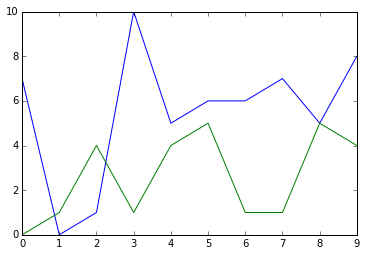

In [1]:
%matplotlib inline

import numpy
from matplotlib import pyplot
import random

x = numpy.arange(10)
y = [random.randint(0, 10) for i in x]
pyplot.plot(x, y)
z = [random.randint(0, 5) for i in x]
pyplot.plot(x, z)

上記のように、xにx座標の配列を、yにy座標の配列を入れることで、簡単に折れ線グラフを描くことができ、さらに重ね書きもできます。

では、このAPIを利用してMNIST + MLPの各epoch毎の識別率を描画してみましょう。

In [14]:
import logging
logging.basicConfig(level=logging.DEBUG)
from mlp import MLP
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split


def mlp_train(n_epoch):
    mnist = fetch_mldata('MNIST original')
    mnist.data = mnist.data.astype(numpy.float32)
    mnist.data /= 255
    mnist.target = mnist.target.astype(numpy.int32)

    data_train, data_test, target_train, target_test = train_test_split(mnist.data, mnist.target)

    # 学習を早めるために、10000個に削減
    data = data_train[:10000], data_test[:10000]
    target = target_train[:10000], target_test[:10000]

    mlp = MLP(data=data, target=target, gpu=-1)
    mlp.train_and_test(n_epoch=n_epoch)
    
    return mlp

mlp = mlp_train(10)
print 'accuracies of training: ', mlp.train_accuracies
print 'accuracies of test: ', mlp.test_accuracies

accuracies of training:  [0.7847999991476535, 0.9129000014066696, 0.9357000011205673, 0.9495000040531159, 0.9593000030517578, 0.9689000082015992, 0.9709000098705292, 0.9723000103235244, 0.9735000085830688, 0.9767000097036361]
accuracies of test:  [0.9214000022411346, 0.9434000033140183, 0.9509000009298325, 0.9578000032901763, 0.9577000033855438, 0.961400004029274, 0.9613000029325485, 0.9608000046014786, 0.9628000038862229, 0.9655000054836274]


MLPを使って、MNISTのデータセットのうち、10000個のデータを10回学習を回した後のmlpオブジェクトには、上記のようにtrain_accuracies, test_accuraciesという変数に各epochの識別率が収められています。それでは、課題です。

### 課題1: MLPの識別率の推移をmatplotlibで可視化してみよう

上記のtrain_accuracies, test_accuraciesをpyplotでプロットしてみましょう。

accuracies of training:  [0.8010000014305114, 0.9188000017404556, 0.938500000834465, 0.949899999499321, 0.9599000018835068, 0.9661000061035157, 0.9706000077724457, 0.9711000120639801, 0.978900009393692, 0.9796000111103058]
accuracies of test:  [0.9071000021696091, 0.9321999996900558, 0.9438000035285949, 0.9472000056505203, 0.9465000009536744, 0.9514000010490418, 0.9553000009059907, 0.9528000020980835, 0.958000003695488, 0.9581000036001206]


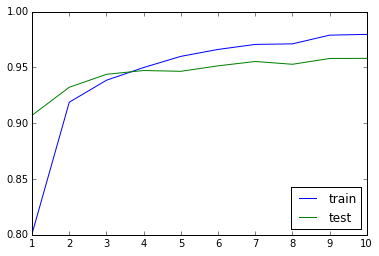

In [13]:
pyplot.ylim(0.8, 1.0)
pyplot.plot(numpy.arange(len(mlp.train_accuracies)) + 1, mlp.train_accuracies, label="train")
pyplot.plot(numpy.arange(len(mlp.test_accuracies)) + 1, mlp.test_accuracies, label="test")
pyplot.legend(loc = 'lower right')

## 画像の描画

次に画像情報の可視化を行っていきます。画像のプロットには、pyplotのimshowという関数を使います。早速、サンプルとしてMNISTのデータをランダム抽出して、50個分、描画するコードを書いてみましょう。

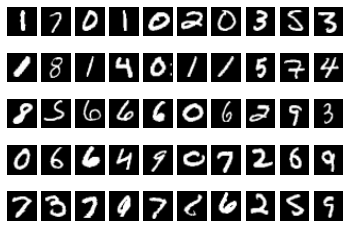

In [20]:
mnist = fetch_mldata('MNIST original')
mnist.data = mnist.data.astype(numpy.float32)

for i in range(5):
    for j in range(10):
        pyplot.subplot(5, 10, 10 * i + j)
        img_idx = random.randint(0, mnist.data.shape[0])
        pyplot.xticks([])
        pyplot.yticks([])
        pyplot.imshow(mnist.data[img_idx, :].reshape(28, 28), cmap='gray')

imshowをつかうと、MLPやCNNの途中経過の状態を描画することが可能になります。試しに、MLPの中間層のデータを描画してみましょう。

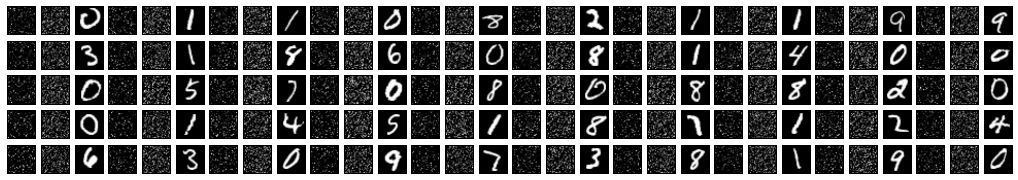

In [50]:
from chainer import Variable
from chainer import FunctionSet
import chainer.functions as F

pyplot.rcParams['figure.figsize'] = (18, 3)

for i in range(5):
    for j in range(0, 30, 3):
        img_idx = random.randint(0, mnist.data.shape[0])        
        img = mnist.data[img_idx, :].reshape(1, 28 * 28)
        idx = 30 * i + j
        #print idx
        ax = pyplot.subplot(5, 30, idx)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img.reshape(28, 28), cmap='gray')
        #print idx + 1
        x = Variable(img / 255)
        h1 = F.relu(mlp.model.l1(x))
        ax = pyplot.subplot(5, 30, idx + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(h1.data.reshape(28, 28), cmap='gray')
        #print idx + 2, "not show"
        h2 = F.relu(mlp.model.l2(h1))
        ax = pyplot.subplot(5, 30, idx + 2)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(h2.data.reshape(28, 28), cmap='gray')

描画すると、フィードフォワードの場合、画像的情報失われてしまっていることがわかります。

では、CNNの場合どうでしょうか？同じ枠組みで取り組んでみましょう。

In [53]:
from cnn import CNN

def cnn_train():
    mnist = fetch_mldata('MNIST original')
    mnist.data = mnist.data.astype(numpy.float32)
    mnist.data /= 255
    mnist.data = mnist.data.reshape(70000, 1, 28, 28)
    mnist.target = mnist.target.astype(numpy.int32)

    data_train, data_test, target_train, target_test = train_test_split(mnist.data, mnist.target)

    data = data_train[:10000], data_test[:10000]
    target = target_train[:10000], target_test[:10000]

    n_outputs = 10
    in_channels = 1

    cnn = CNN(
        data=data,
        target=target,
        gpu=-1,
        in_channels=in_channels,
        n_outputs=n_outputs,
        n_hidden=100
    )

    cnn.train_and_test(n_epoch=2)
    return cnn

cnn = cnn_train()
print "train accuracies: ", cnn.train_accuracies
print "test accuracies: ", cnn.test_accuracies

train accuracies:  [0.6968999992311001, 0.9172000008821487]
test accuracies:  [0.9408000016212463, 0.9543999999761581]


### 課題2: CNNの中間層（畳み込み層）を描画してみよう 

では、上記で学習したCNNを使って、中間層のデータを描画してみましょう。具体的には、mnist.dataの中から１つサンプルを撮ってきて、フォワード計算を行い、中間のプーリング層の出力32チャネルを描画してみましょう。

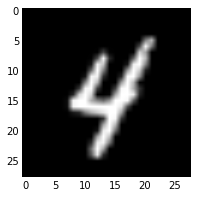

In [55]:
sample = mnist.data[random.randint(0, 70000)]

pyplot.imshow(sample.reshape(28, 28),  cmap="gray")

conv1 shape:  (1, 32, 12, 12)


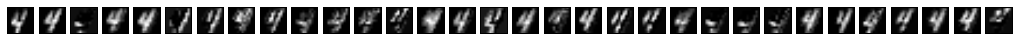

In [69]:
x = sample / 255
x.shape = 1, 1, 28, 28
x = Variable(x)

conv1 = F.max_pooling_2d(F.relu(cnn.model.conv1(x)), ksize=2, stride=2)
print 'conv1 shape: ', conv1.data.shape

for i in xrange(32):
    pyplot.subplot(1, 32, i)
    pyplot.xticks([])
    pyplot.yticks([])
    pyplot.imshow(conv1.data[0, i, :, :].reshape(12, 12), cmap="gray")

conv2 shape:  (1, 32, 3, 3)


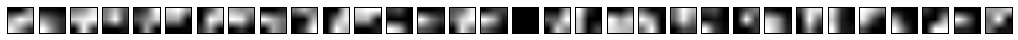

In [70]:
conv2 = F.max_pooling_2d(F.relu(cnn.model.conv2(conv1)), ksize=3, stride=3)
print 'conv2 shape: ', conv2.data.shape

for i in xrange(32):
    pyplot.subplot(1, 32, i)
    pyplot.xticks([])
    pyplot.yticks([])
    pyplot.imshow(conv2.data[0, i, :, :].reshape(3, 3), cmap="gray")